Ensamble de modelos

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from scripts import featurizer_rf as featurer_rf


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,precision_score ,f1_score

In [2]:
df = pd.read_csv("../data/dataset-procesado.csv", index_col=False)

In [3]:
df_trabajo = featurer_rf.featurizer(df)

----rf-featurizer----


In [4]:
#Separo en train y test para trabajar los modelos
df_trabajo_x=df_trabajo.drop(['target'], axis='columns', inplace=False)

df_trabajo_y = df_trabajo['target'].copy()
#Uso parametro stratify para balancear el target dentro de cada ser de datos de train test
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, df_trabajo_y, test_size=0.3, random_state=1, stratify = df_trabajo_y)

Necesitamos el modelo Random Forest y el XGBoost

In [5]:
rf_cv = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5], 
               "max_features":["sqrt", "log2"],
               "min_samples_split" : [2, 5], 
               "n_estimators": [10,50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

In [6]:
#gs_fit = gs.fit(X = x_train, y = y_train)
#best_params_rfc = gs_fit.best_params_

best_params_rfc = {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}

print(best_params_rfc)

#{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}

{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}


In [7]:
rfc_best_model = RandomForestClassifier(**best_params_rfc)

Hacemos lo mismo pero con el XGBoost

In [8]:
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier
from scripts import featurizer_xgb


In [9]:
df_trabajo_xgb = featurizer_xgb.featurizer(df)

----xgb-featurizer----


In [10]:
X_xgb = df_trabajo_xgb.drop(axis = 1, columns = ['target'])
y_xgb = df_trabajo_xgb.target

features = X_xgb.columns

#Set hyperparameters dictionary
param_dist = {'n_estimators':[50, 100],
              'max_depth':[5,10],              
              'subsample': [0.5,0.8,1],
              'colsample_bytree': [0.5,0.8,1],              
              'learning_rate':[0.01, 0.1, 0.3]
              }

In [11]:
xgb = XGBClassifier()
random_search_xgb = RandomizedSearchCV(xgb,
                                       param_distributions = param_dist,
                                       n_iter = 2,
                                       scoring = 'roc_auc',
                                       cv = 5,
                                       n_jobs = -1,
                                       verbose=5)
#random_search_xgb.fit(x_train, y_train)

In [12]:
#params_opt_xgb = random_search_xgb.best_params_

params_opt_xgb = {'subsample': 0.8,'n_estimators': 100,'max_depth': 5,'learning_rate': 0.2,'colsample_bytree': 0.5}

In [13]:
xgbModelBestParams = XGBClassifier(**params_opt_xgb)

In [14]:
from sklearn.ensemble import VotingClassifier

In [15]:
vot_clf = VotingClassifier(estimators = [('rnd', rfc_best_model),('xgb', xgbModelBestParams)], voting = 'hard')

In [16]:
vot_clf.fit(x_train, y_train)
pred_vot_clf = vot_clf.predict(x_test)

df_resultados_vot_clf=pd.DataFrame(zip(y_test,pred_vot_clf),columns=['test','predicted'])

/home/bear/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:44:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Tabla de confusion de test: 


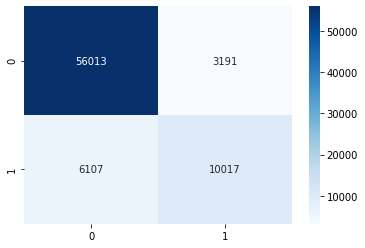

In [17]:
tabla=confusion_matrix(df_resultados_vot_clf['test'], df_resultados_vot_clf['predicted'])

print('Tabla de confusion de test: ')

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

Tabla de confusion de entrenamiento: 


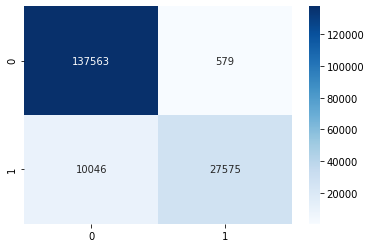

In [18]:
y_train_vot_clf = vot_clf.predict(x_train)
tabla=confusion_matrix(y_train, y_train_vot_clf)
print('Tabla de confusion de entrenamiento: ')
grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [19]:
def results_comparation(df_predict):
    df_predict["success"] = (df_predict["test"] == df_predict["predicted"])
    df_predict["success"].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("Cantidad de valores predecidos correctamente") 
    plt.show()

    precicion = precision_score(df_predict['test'], df_predict['predicted'])
    f1=f1_score(df_predict['test'], df_predict['predicted'])
    recall = recall_score(df_predict['test'], df_predict['predicted'])
    
    print(f"Precision score: \t{round(precicion,3)}")
    print(f"Recall score: \t\t{round(recall,3)}")
    print(f"F1 score: \t\t{round(f1,3)}")

    accuracy=accuracy_score(df_predict['test'], df_predict['predicted'], normalize=True)
    print("Tiene una accuracy del: " + str(round(accuracy, 3)) + "% como muestra el pie chart")

In [20]:
print("Accuracy de entrenamiento : ", accuracy_score(y_train, y_train_vot_clf))
print("Accuracy de test : ", accuracy_score(df_resultados_vot_clf['test'], df_resultados_vot_clf['predicted']))
print('\n')
print('Se puede ver que la precicion para el voting classifier no tiene overfitting ni underfitting')

Accuracy de entrenamiento :  0.9395492794274107
Accuracy de test :  0.8765664825828378


Se puede ver que la precicion para el voting classifier no tiene overfitting ni underfitting


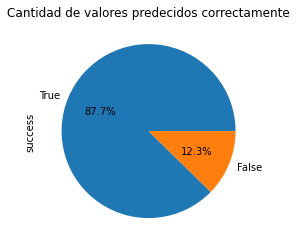

Precision score: 	0.758
Recall score: 		0.621
F1 score: 		0.683
Tiene una accuracy del: 0.877% como muestra el pie chart


In [21]:
results_comparation(df_resultados_vot_clf)

In [22]:
vot_clf

VotingClassifier(estimators=[('rnd',
                              RandomForestClassifier(criterion='entropy',
                                                     min_samples_leaf=5,
                                                     n_estimators=50)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.2,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=0.8, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None))])

In [23]:
from joblib import dump, load
dump(vot_clf, 'voting.joblib') 

['voting.joblib']